# CNN - 가위바위보

[https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors](https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors) 에서 배포하는 데이터셋

아래 URL을 통해 기본 파일 정리가 수행된 파일을 내려 받는다.

> [https://drive.google.com/file/d/1x6YsEBCSuxAKbmUbF-U0ntXoNwELoTVr/view?usp=sharing](https://drive.google.com/file/d/1x6YsEBCSuxAKbmUbF-U0ntXoNwELoTVr/view?usp=sharing)

## #01. 준비작업 

### [1] 패키지 참조


In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action="ignore")

from hossam.util import *
from hossam.plot import *
from hossam.tensor import *

import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-23 11:01:11.967428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 11:01:11.967459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 11:01:11.968081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 11:01:11.972033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 11:01:12.466173: W tensorflow/compiler/tf2

### [2] 데이터셋 준비하기

#### (1) 파일 압축 해제

데이터셋을 캐글로부터 다운로드 받은 후 적절한 위치에 압축을 해제한다.

압축을 해제하면 cats 폴더와 dogs 폴더에 각각 5000장의 이미지가 포함되어 있다.


In [2]:
plt.rcParams["font.family"] = 'D2Coding'

In [3]:
# 압축파일의 경로
workspace_dir = "./data"
file_path = os.path.join(workspace_dir, "rock-paper-scissors.zip")

# 압축을 해제할 경로
extract_dir = os.path.join(workspace_dir, "rock-paper-scissors")

# 해당 폴더가 없다면 폴더를 생성하고 파일의 압축을 해제
# if not os.path.exists(extract_dir):
#     os.mkdir(extract_dir)

#     zip_ref = zipfile.ZipFile(file_path, "r")
#     zip_ref.extractall(extract_dir)
#     zip_ref.close()

#### (2) 임의의 이미지 확인

#####  이미지

실행시마다 표시 이미지가 랜덤하게 바뀐다.


In [4]:
subdir = os.listdir(extract_dir)
subdir

['paper', 'rock', 'scissors']

./data/rock-paper-scissors/paper


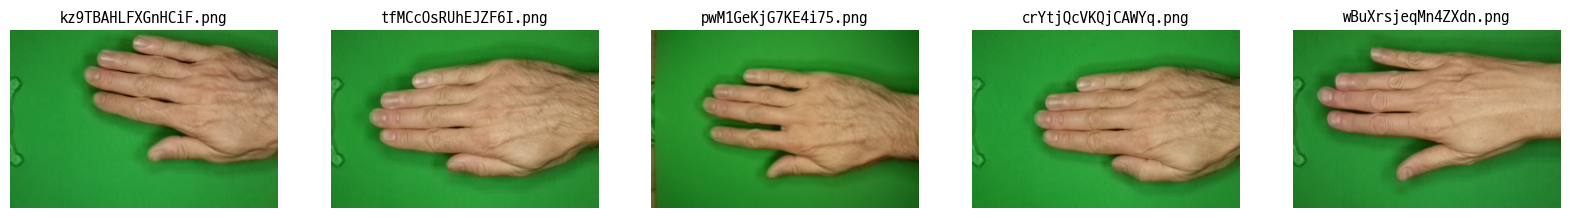

./data/rock-paper-scissors/rock


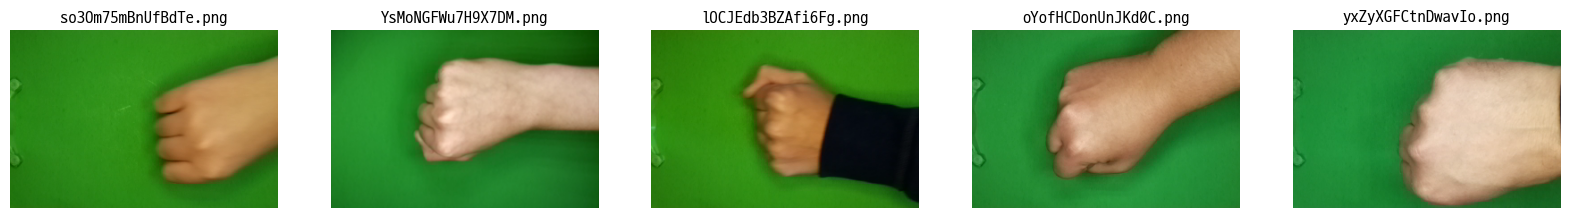

./data/rock-paper-scissors/scissors


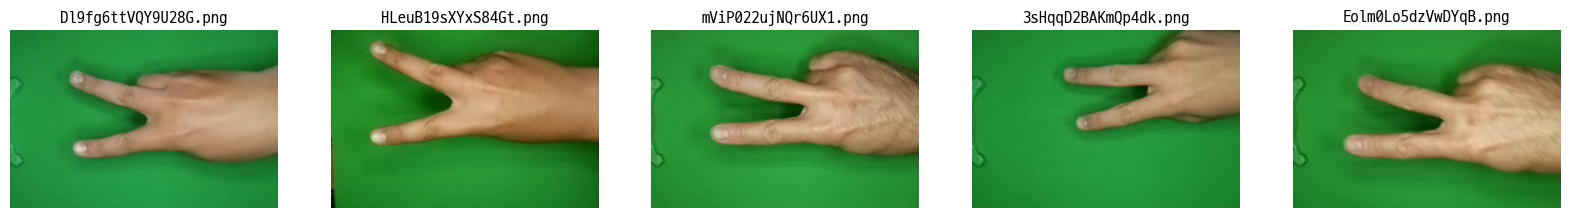

In [5]:
for s in subdir:
    path = os.path.join(extract_dir, s)
    print(path)

    image_list = os.listdir(path)
    image_count = len(image_list)

    rand = np.random.random_integers(0, image_count - 1, 5)

    fig, ax = plt.subplots(1, 5, figsize=(20, 3), dpi=100)

    for i in range(0, len(ax)):
        file_path = os.path.join(path, image_list[rand[i]])
        img = load_image(file_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(image_list[rand[i]])

    plt.show()
    plt.close()

## #02. 이미지 데이터 전처리

### [1] 이미지 전처리기 생성


In [6]:
image_gen = ImageDataGenerator(
    rescale=1.0 / 255,  # 정규화(색상값을 0~1사이로 변경함)
    rotation_range=30,  # 이미지 무작위 회전 (30도 이내)
    width_shift_range=0.2,  # 가로 방향 이동 범위 (무작위 20% 이내)
    height_shift_range=0.2,  # 세로 방향 이동 범위 (무작위 20% 이내)
    shear_range=0.2,  # 층 밀리기 강도 (무작위 20% 이내)
    zoom_range=0.2,  # 줌 범위 (무작위 20% 이내)
    brightness_range=[0.5, 1.0],  # 이미지 밝기
    horizontal_flip=True,  # 수평 뒤집기
    vertical_flip=True,  # 수직 뒤집기
    fill_mode="nearest",  # 이미지 변형 시 채울 픽셀
    validation_split=0.2,  # 검증 데이터 비율
)

### [2] 이미지 데이터 전처리 수행

#### (1) 훈련용 이미지 데이터 생성


In [7]:
classes = os.listdir(extract_dir)
classes

['paper', 'rock', 'scissors']

In [8]:
train_set = image_gen.flow_from_directory(
    extract_dir,  # 이미지 파일이 위치한 폴더
    classes=classes,  # 분류할 클래스명
    batch_size=16,  # 배치 사이즈
    class_mode="categorical",  # 다항분류용임을 명시(binary or categorical)
    target_size=(64, 64),  # 변환될 이미지 해상도
    shuffle=True,  # 이미지 섞기
    color_mode="rgb",  # 컬러 이미지
    seed=get_random_state(),  # 랜덤 시드값
    subset="training",  # 훈련용 데이터 생성임을 명시
)

train_set.class_indices

Found 1751 images belonging to 3 classes.


{'paper': 0, 'rock': 1, 'scissors': 2}

#### (2) 검증용 데이터 생성


In [9]:
test_set = image_gen.flow_from_directory(
    extract_dir,  # 이미지 파일이 위치한 폴더
    classes=classes,  # 분류할 클래스명
    batch_size=16,  # 배치 사이즈
    class_mode="categorical",  # 다항분류용임을 명시(binary or categorical)
    target_size=(64, 64),  # 변환될 이미지 해상도
    shuffle=True,  # 이미지 섞기
    color_mode="rgb",  # 컬러 이미지
    seed=get_random_state(),  # 랜덤 시드값
    subset="validation",  # 검증용 데이터 생성임을 명시
)

test_set.class_indices

Found 437 images belonging to 3 classes.


{'paper': 0, 'rock': 1, 'scissors': 2}

## #03. 훈련 모델 적합

### [1] 모델 정의하기


In [10]:
model = tf_create(
    layer=[
        # cnn (1)
        {
            "type": "conv2d",
            "filters": 16,
            "kernel_size": 6,
            "padding": "same",
            "input_shape": (64, 64, 3),
        },
        {"type": "batchnorm"},
        {"type": "activation", "function": "relu"},
        {"type": "maxpooling", "pool_size": (2, 2)},
        {"type": "dropout", "rate": 0.1},
        # cnn (2)
        {
            "type": "conv2d",
            "filters": 32,
            "kernel_size": 5,
            "padding": "same",
        },
        {"type": "batchnorm"},
        {"type": "activation", "function": "relu"},
        {"type": "maxpooling", "pool_size": (2, 2)},
        {"type": "dropout", "rate": 0.1},
        # cnn (3)
        {
            "type": "conv2d",
            "filters": 64,
            "kernel_size": 4,
            "padding": "same",
        },
        {"type": "batchnorm"},
        {"type": "activation", "function": "relu"},
        {"type": "maxpooling", "pool_size": (2, 2)},
        {"type": "dropout", "rate": 0.1},
        # cnn (4)
        {
            "type": "conv2d",
            "filters": 128,
            "kernel_size": 3,
            "padding": "same",
        },
        {"type": "batchnorm"},
        {"type": "activation", "function": "relu"},
        {"type": "maxpooling", "pool_size": (2, 2)},
        {"type": "dropout", "rate": 0.1},
        # 단일층
        {"type": "flatten"},
        {"type": "dense", "units": 64},
        {"type": "batchnorm"},
        {"type": "activation", "function": "relu"},
        {"type": "dense", "units": 3},  # 출력층의 수는 클래스의 수와 동일해야 함
        {"type": "batchnorm"},
        {"type": "activation", "function": "softmax"},  # 다중클래스 분류용 활성화 함수
    ],
    optimizer="adam",
    loss="categorical_crossentropy",  # 다중클래스 분류용 손실함수
    metrics=["acc"],
)

model.summary()

{'type': 'conv2d', 'filters': 16, 'kernel_size': 6, 'padding': 'same', 'input_shape': (64, 64, 3)}
{'type': 'batchnorm'}
{'type': 'activation', 'function': 'relu'}
{'type': 'maxpooling', 'pool_size': (2, 2)}
{'type': 'dropout', 'rate': 0.1}
{'type': 'conv2d', 'filters': 32, 'kernel_size': 5, 'padding': 'same'}
{'type': 'batchnorm'}
{'type': 'activation', 'function': 'relu'}
{'type': 'maxpooling', 'pool_size': (2, 2)}
{'type': 'dropout', 'rate': 0.1}
{'type': 'conv2d', 'filters': 64, 'kernel_size': 4, 'padding': 'same'}
{'type': 'batchnorm'}
{'type': 'activation', 'function': 'relu'}
{'type': 'maxpooling', 'pool_size': (2, 2)}
{'type': 'dropout', 'rate': 0.1}
{'type': 'conv2d', 'filters': 128, 'kernel_size': 3, 'padding': 'same'}
{'type': 'batchnorm'}
{'type': 'activation', 'function': 'relu'}
{'type': 'maxpooling', 'pool_size': (2, 2)}
{'type': 'dropout', 'rate': 0.1}
{'type': 'flatten'}
{'type': 'dense', 'units': 64}
{'type': 'batchnorm'}
{'type': 'activation', 'function': 'relu'}
{'t

2024-04-23 11:01:13.964093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22433 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:08:00.0, compute capability: 8.6


### [2] 학습하기


Epoch 1/1000


2024-04-23 11:01:15.215714: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-23 11:01:15.409652: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-23 11:01:15.470955: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-23 11:01:15.567542: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-23 11:01:16.353041: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbc21f14b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-23 11:01:16.353065: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 30

109/109 [==============================] - 9s 50ms/step - loss: 0.7122 - acc: 0.7095 - val_loss: 1.7400 - val_acc: 0.3310 - lr: 0.0010
Epoch 2/1000
109/109 [==============================] - 5s 42ms/step - loss: 0.4005 - acc: 0.9084 - val_loss: 1.9465 - val_acc: 0.3287 - lr: 0.0010
Epoch 3/1000
109/109 [==============================] - 5s 44ms/step - loss: 0.3423 - acc: 0.9205 - val_loss: 1.3429 - val_acc: 0.5000 - lr: 0.0010
Epoch 4/1000
109/109 [==============================] - 5s 44ms/step - loss: 0.2783 - acc: 0.9406 - val_loss: 1.4682 - val_acc: 0.4977 - lr: 0.0010
Epoch 5/1000
109/109 [==============================] - 5s 42ms/step - loss: 0.2537 - acc: 0.9533 - val_loss: 0.9611 - val_acc: 0.6806 - lr: 0.0010
Epoch 6/1000
109/109 [==============================] - 5s 42ms/step - loss: 0.2195 - acc: 0.9562 - val_loss: 0.4339 - val_acc: 0.8218 - lr: 0.0010
Epoch 7/1000
109/109 [==============================] - 5s 42ms/step - loss: 0.2024 - acc: 0.9614 - val_loss: 0.8383 - val_ac

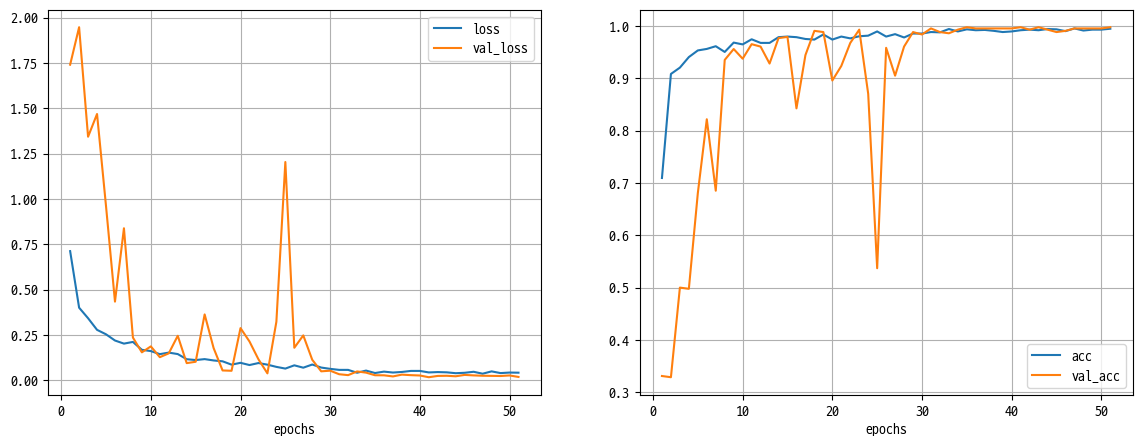

CPU times: user 4min 33s, sys: 5.13 s, total: 4min 38s
Wall time: 4min 5s


In [11]:
%%time

batch_size = 16

result = tf_train(
    model=model,
    x_train=train_set,
    x_test=test_set,
    epochs=1000,
    steps_per_epoch=train_set.samples // batch_size,
    validation_steps=test_set.samples // batch_size,
    verbose=1
)

tf_result(result)

## #04. 학습 결과 확인

### [1] 검증 데이터의 라벨 확인


In [12]:
y = test_set.classes
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

### [2] 검증 데이터에 대한 예측값


In [13]:
y_pred_proba = model.predict(test_set)
y_pred_proba

28/28 [==============================] - 1s 34ms/step


array([[0.01154321, 0.979729  , 0.00872777],
       [0.00223072, 0.00314959, 0.9946197 ],
       [0.001761  , 0.00512536, 0.9931136 ],
       ...,
       [0.9960228 , 0.00209729, 0.00187983],
       [0.9821468 , 0.00947477, 0.00837843],
       [0.00154651, 0.00227625, 0.9961772 ]], dtype=float32)

In [14]:
y_pred = np.argmax(y_pred_proba, axis=1)
y_pred

array([1, 2, 2, 2, 1, 0, 1, 1, 2, 0, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       1, 0, 2, 1, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1,
       0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 2, 1, 2, 1, 0, 1, 2, 1, 1, 2, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1, 0, 1, 2, 0, 2,
       1, 1, 2, 0, 1, 0, 0, 2, 1, 2, 2, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       0, 1, 1, 1, 0, 0, 2, 2, 1, 2, 0, 2, 1, 2, 0, 0, 1, 1, 0, 2, 1, 0,
       2, 2, 1, 2, 0, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2, 0, 2, 1, 0, 1, 0, 2,
       2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 0, 1, 1, 2, 2, 0, 0, 2, 0, 1, 1, 2,
       1, 0, 2, 2, 1, 0, 0, 1, 2, 2, 1, 0, 0, 0, 1, 2, 2, 1, 0, 2, 0, 1,
       2, 0, 1, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 1, 2, 1,
       1, 2, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 2, 1, 2, 2, 1, 2, 0, 2, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 2, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2,
       2, 0, 0, 2, 0, 2, 2, 2, 0, 1, 1, 0, 1, 2, 0, 0, 1, 2, 0, 2, 1, 2,
       2, 0, 2, 0, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 1,

### [3] 혼동 행렬


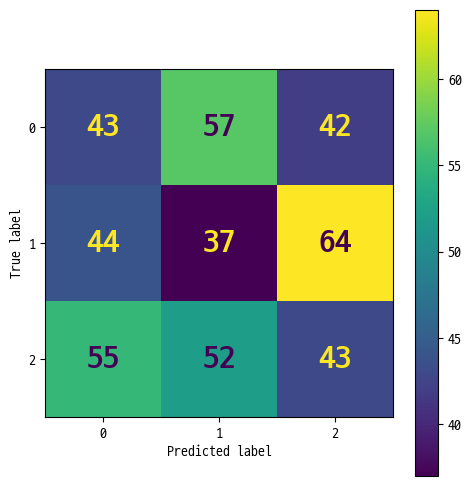

In [15]:
my_confusion_matrix(y, y_pred, figsize=(5, 5), dpi=100)

## #05. 학습 결과 적용

### [1] 임의의 이미지 가져오기


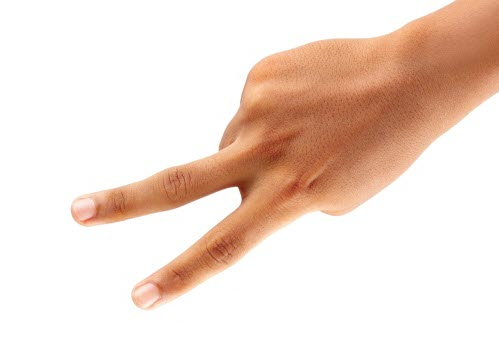

In [16]:
가위_img = load_image("res/가위.jpg")
가위_img

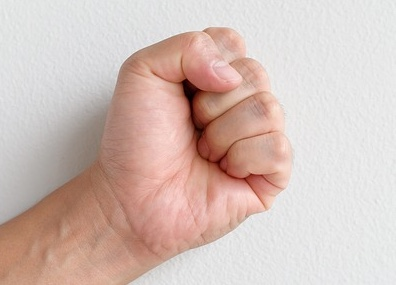

In [17]:
바위_img = load_image("res/바위.jpg")
바위_img

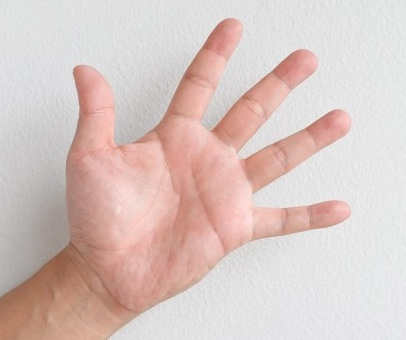

In [18]:
보_img = load_image("res/보.jpg")
보_img

### [2] 이미지 전처리


In [19]:
# 훈련 데이터와 동일한 크기로 리사이즈
가위_tune = tune_image(가위_img, size=(64, 64), contrast=1.5)
바위_tune = tune_image(바위_img, size=(64, 64), contrast=1.5)
보_tune = tune_image(보_img, size=(64, 64), contrast=1.5)

# 이미지 데이터 변환
가위_flow = image_gen.flow(np.array([가위_tune]))
바위_flow = image_gen.flow(np.array([바위_tune]))
보_flow = image_gen.flow(np.array([보_tune]))

# 예측값 생성
가위_pred_proba = model.predict(가위_flow)
가위_pred = np.argmax(가위_pred_proba)
print(가위_pred_proba, 가위_pred)

바위_pred_proba = model.predict(바위_flow)
바위_pred = np.argmax(바위_pred_proba)
print(바위_pred_proba, 바위_pred)

보_pred_proba = model.predict(보_flow)
보_pred = np.argmax(보_pred_proba)
print(보_pred_proba, 보_pred)

1/1 [==============================] - 0s 216ms/step
[[0.61020046 0.28403556 0.10576393]] 0
1/1 [==============================] - 0s 21ms/step
[[0.00726355 0.976674   0.01606247]] 1
1/1 [==============================] - 0s 19ms/step
[[0.12429243 0.8537484  0.02195919]] 1


#### [3] 예측 결과 확인


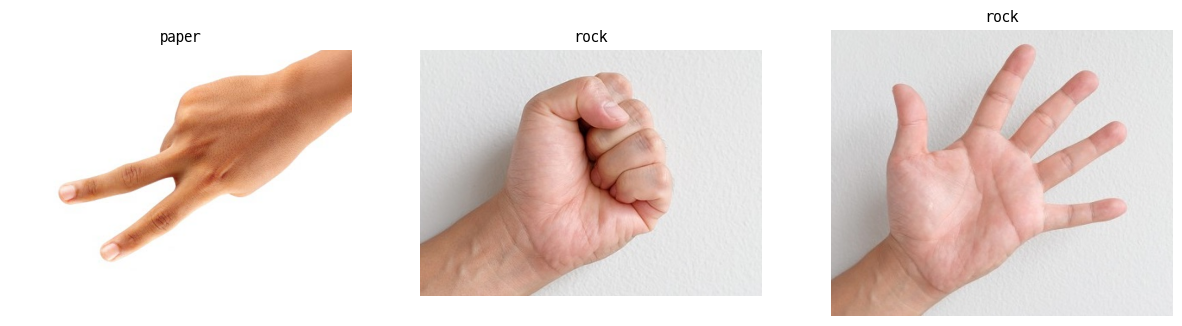

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=100)

ax[0].imshow(가위_img)
ax[0].axis("off")
ax[0].set_title(classes[가위_pred])

ax[1].imshow(바위_img)
ax[1].axis("off")
ax[1].set_title(classes[바위_pred])

ax[2].imshow(보_img)
ax[2].axis("off")
ax[2].set_title(classes[보_pred])

plt.show()
plt.close()